# VC - Entrega Práctica 3
---
 - Luis Martín Pérez
- Andrea Santana López

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

### TAREA 1 - Clasificador de dinero en monedas

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv
monedas_dimensiones = {
    '2_euros': 25.75,
    '1_euro': 23.25,
    '50_centimos': 24.25,
    '20_centimos': 22.25,
    '10_centimos': 19.75,
    '5_centimos': 21.25,
    '2_centimos': 18.75,
    '1_centimo': 16.25
}

moneda_valor = {
    '2_euros': 2.0,
    '1_euro': 1.0,
    '50_centimos': 0.5,
    '20_centimos': 0.2,
    '10_centimos': 0.1,
    '5_centimos': 0.05,
    '2_centimos': 0.02,
    '1_centimo': 0.01
}

def mostrar_imagen_reducida(nombre_ventana, img, ancho_max=800, alto_max=600):
    h, w = img.shape[:2]
    escala = min(ancho_max / w, alto_max / h)
    nuevo_tamano = (int(w * escala), int(h * escala))
    img_redimensionada = cv2.resize(img, nuevo_tamano, interpolation=cv2.INTER_AREA)
    cv2.imshow(nombre_ventana, img_redimensionada)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def calcular_precio_moneda(imagen_ruta):
    img = cv2.imread(imagen_ruta)
    if img is None:
        print("Error: No se pudo cargar la imagen")
        return
    
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pimg = cv2.medianBlur(gris, 5)

    circulos_detectados = cv2.HoughCircles(pimg, cv2.HOUGH_GRADIENT, 1, 100,
                                           param1=100, param2=50, minRadius=50, maxRadius=150)
    
    if circulos_detectados is None:
        print("No se han detectado monedas")
        return
    
    circulos = np.uint16(np.around(circulos_detectados))[0]

    punto_referencia_1_euro = {"radio": None, "circulo": None}

    def evento_click(event, x, y, flags, userdata):
        if event == cv2.EVENT_LBUTTONDOWN:
            distancia_minima, circulo_ref = 1e9, None
            for cx, cy, r in circulos.astype(float):
                dist = np.sqrt((x - cx)**2 + (y - cy)**2)
                if dist < distancia_minima:
                    distancia_minima, circulo_ref = dist, (cx, cy, r)
            if circulo_ref is not None:
                punto_referencia_1_euro["radio"] = circulo_ref[2]
                punto_referencia_1_euro["circulo"] = circulo_ref
                print(f"Moneda de referencia seleccionada - Radio: {circulo_ref[2]} píxeles")
                cv2.destroyWindow("Selecciona moneda de 1 euro")

    cv2.imshow("Selecciona moneda de 1 euro", img)
    cv2.setMouseCallback("Selecciona moneda de 1 euro", evento_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if punto_referencia_1_euro["radio"] is None:
        print("No se ha seleccionado ninguna moneda de referencia")
        return

    # Datos de referencia
    radio_ref = punto_referencia_1_euro["radio"]
    diametro_1_euro_mm = monedas_dimensiones['1_euro']

    # Cálculo del factor mm/píxel (con la moneda de referencia)
    factor_mm_por_pixel = diametro_1_euro_mm / (2 * radio_ref)

    # Definición de rangos base en mm
    rangos_base = {
        '2_euros': (25.7, 26.5),
        '1_euro': (23.0, 24.0),
        '50_centimos': (24.0, 25.7),
        '20_centimos': (21.0, 23.0),
        '10_centimos': (19.4, 20.5),
        '5_centimos': (20.5, 21.3),
        '2_centimos': (18.0, 19.4),
        '1_centimo': (15.5, 17.0)
    }

    #  basado en diferencia del 1 euro
    diametro_detectado_1_euro = 2 * radio_ref * factor_mm_por_pixel
    diferencia_relativa = (diametro_detectado_1_euro - diametro_1_euro_mm) / diametro_1_euro_mm
    print(f"\nDiámetro detectado 1€: {diametro_detectado_1_euro:.2f} mm")
    print(f"Diferencia relativa: {diferencia_relativa * 100:+.2f}%")

    # Aplicar el mismo porcentaje de corrección al resto de monedas
    rangos_ajustados = {}
    for nombre, (min_d, max_d) in rangos_base.items():
        if nombre == '1_euro':
            rangos_ajustados[nombre] = (min_d, max_d)
        else:
            min_corr = min_d * (1 + diferencia_relativa)
            max_corr = max_d * (1 + diferencia_relativa)
            rangos_ajustados[nombre] = (min_corr, max_corr)

    total_dinero = 0.0
    monedas_detectadas = []

    circulos_ordenados = sorted(circulos, key=lambda c: (c[1], c[0]))

    for (x, y, r) in circulos_ordenados:
        diametro_mm = 2 * r * factor_mm_por_pixel
        moneda_tipo = "desconocida"
        for nombre, (min_d, max_d) in rangos_ajustados.items():
            if min_d <= diametro_mm <= max_d:
                moneda_tipo = nombre
                break

        total_dinero += moneda_valor.get(moneda_tipo, 0)
        monedas_detectadas.append(moneda_tipo)

        cv2.circle(img, (x, y), r, (0, 255, 0), 2)
        cv2.putText(img, f"{moneda_tipo} ({diametro_mm:.1f}mm)", (x - r, y - r - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    print(f"\nTotal estimado: {total_dinero:.2f} € ({len(monedas_detectadas)} monedas)")
    print("Monedas detectadas:", monedas_detectadas)
    
   #mostrar_imagen_reducida("Resultado detección", img)
    cv2.imshow("Selecciona moneda de 1 euro", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
# Ejecutar   
calcular_precio_moneda('Monedas.jpg')


Por favor, haz click en la moneda de 1 euro para usarla como referencia.
Moneda de referencia seleccionada - Radio: 93.00 píxeles

Diámetro detectado 1€: 23.25 mm
Diferencia relativa: +0.00%

Total estimado: 3.70 € (8 monedas)
Monedas detectadas: ['2 euro', '10 centimos', '1 euro', '2 centimos', '50 centimos', '2 centimos', '5 centimos', '1 centimo']


# Clasificador Microplasticos


Total de muestras extraídas: 302

--- Resultados de Random Forest ---
Precisión del clasificador (Test): 0.4725


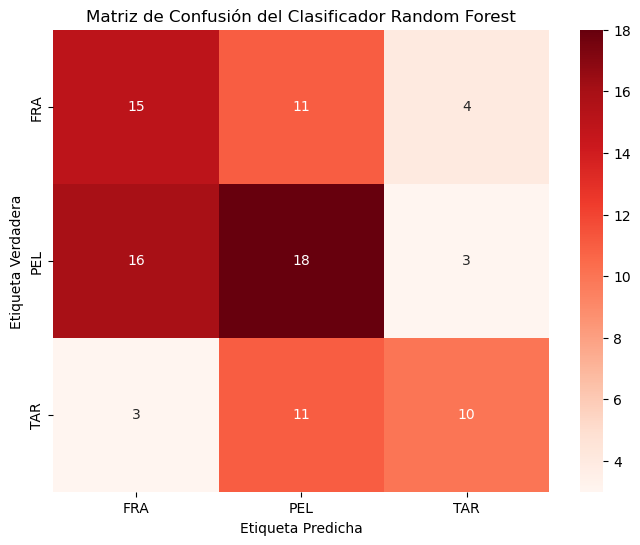

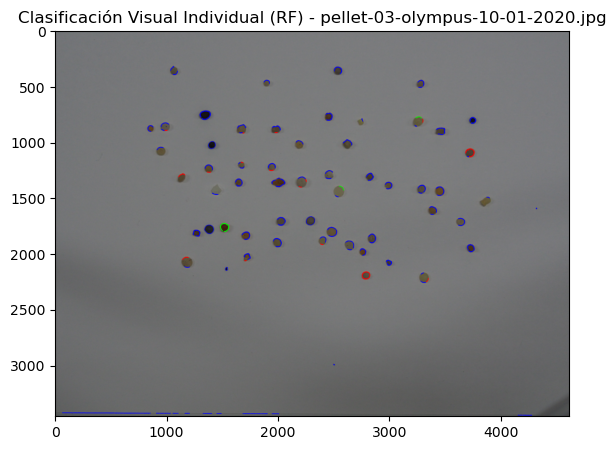

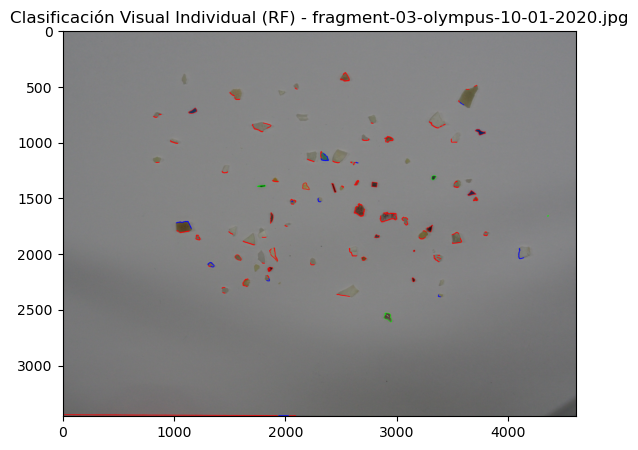

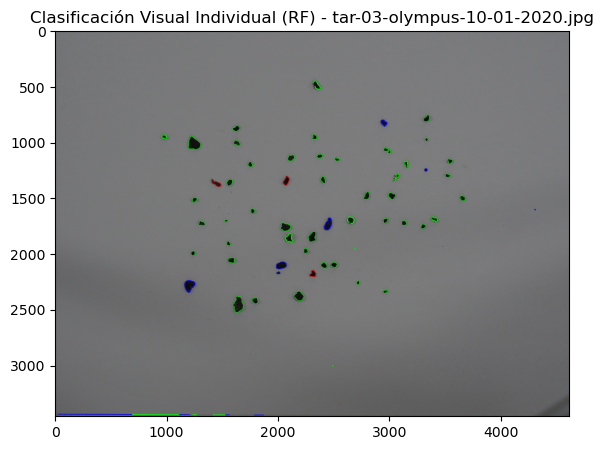

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 1. Inicialización y Carga de Imágenes ---
features_list = [] 
labels_list = []
label_map = {"FRA": 0, "PEL": 1, "TAR": 2}
reverse_label_map = {v: k for k, v in label_map.items()}

# Lista de imágenes a procesar con su etiqueta real
images_data = [
    {"path": "./MicroplasticImages/pellet-03-olympus-10-01-2020.jpg", "label": "PEL"},
    {"path": "./MicroplasticImages/fragment-03-olympus-10-01-2020.jpg", "label": "FRA"},
    {"path": "./MicroplasticImages/tar-03-olympus-10-01-2020.jpg", "label": "TAR"},
]
# Colores para dibujar microplasticos detectados
color_map_bgr = {
    0: (0, 0, 255),    # FRA (Rojo)
    1: (255, 0, 0),    # PEL (Azul)
    2: (0, 255, 0)     # TAR (Verde)
}
def process_contours(image_path,microplastic_label,is_training):
      #Comprobamos que la imagen existe
      img_bgr = cv2.imread(image_path)
      img_with_predictions = img_bgr.copy()
      if img_bgr is None:
        print(f"Error: No se pudo cargar la imagen en {image_path}")
        return
      # Preprocesamiento: Escala de grises y desenfoque
      img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
      img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
      # Umbral Adaptativo Gaussiano
      thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 5) 
      # Encontrar contornos: clave para objetos individuales
      contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      for contour in contours:
        area = cv2.contourArea(contour)
        # Filtro de área mínima
        if area > 50:
            perimeter = cv2.arcLength(contour, True)
            
            if not is_training:
                predict_and_draw_contours(
                    [area, perimeter], 
                    rf_model, 
                    X.columns,
                    contour,         
                    img_with_predictions 
                )
            else:
               process_data_training([area,perimeter], microplastic_label)
      if not is_training:
           plt.figure(figsize=(10, 5))
           plt.title(f"Clasificación Visual Individual ")
           plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
           plt.show()


def predict_and_draw_contours(params, classifier, features_cols,contour, img_with_predictions):
      # Crear el dato para la predicción
    new_feature = pd.DataFrame([params], columns=features_cols)   
    
    # Predecir la clase
    predicted_label_code = classifier.predict(new_feature)[0] 
    predicted_class = reverse_label_map[predicted_label_code]
    color = color_map_bgr.get(predicted_label_code, (255, 255, 255))
    
    # Dibuja el contorno del objeto
    cv2.drawContours(img_with_predictions, [contour], -1, color, 3)
      
            
def process_data_training(params, microplastic_label):
    #Añadir los datos para el entrenamiento
    features_list.append(params)
    labels_list.append(microplastic_label) 
  

for item in images_data:
    process_contours(item["path"], label_map[item["label"]],True)

# Preparación de Datos y Entrenamiento
X = pd.DataFrame(features_list, columns=['Area', 'Perimetro'])
y = pd.Series(labels_list)
print(f"\nTotal de muestras extraídas: {len(X)}")
# División y Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#Entrenamiento de los datos
rf_model.fit(X_train, y_train)

# Predicción y Evaluación
y_pred = rf_model.predict(X_test)
print('\n--- Resultados de Random Forest ---')
print(f"Precisión del clasificador (Test): {accuracy_score(y_test, y_pred):.4f}")

# --- MATRIZ DE CONFUSIÓN ---
cm = confusion_matrix(y_test, y_pred)
class_names = list(label_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión del Clasificador Random Forest')
plt.show()
for item in images_data:
    process_contours(item["path"],"",False)